Brent Michael Haase
C964 - COMPUTER SCIENCE CAPSTONE
Wireless Link RSL Change Prediction

Import all necessary libraries

In [344]:
import requests
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from ipywidgets import interact, widgets, Dropdown
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

Set dataset folder and radio data filenames

In [345]:
data_folder = 'https://raw.githubusercontent.com/brenttoast/C964_Project/main/data/'
file_type = '.json'

In [346]:
radio_data = [
    'noc_bz',
    'noc_bv',
    'noc_col',
    'noc_gwt',
    'noc_he',
    'noc_hg',
    'noc_hw',
    'noc_sar',
    'noc_tt',
    'noc_tur'
]

Download and process temperature/radio information and merge into a single dataframe object

In [347]:
def json_download(url):
    response = requests.get(url)
    response.raise_for_status()
    return response.json()

temp_data = json_download(f'{data_folder}temps{file_type}')
temp_data = pd.DataFrame(temp_data).rename(columns={"dt": "time"})
temp_data = temp_data[['time', 'main']]
temp_data['temp'] = temp_data['main'].apply(lambda x: x['temp'])
temp_data = temp_data[['time', 'temp']]
temp_data['time'] = pd.to_datetime(temp_data['time'], unit='s')
temp_data['time'] = temp_data['time'].dt.tz_localize('Etc/GMT')
temp_data['time'] = temp_data['time'] + pd.DateOffset(hours=1, minutes=30)
radio_stats_all = []

for json_file in radio_data:
    radio_info = json_download(f'{data_folder}{json_file}{file_type}')
    
    azimuth = radio_info['meta']['azimuth']
    height = radio_info['meta']['height']
    radio_info = pd.DataFrame(radio_info["data"]).rename(columns={"sensor": "rsl"})
    radio_info['link_name'] = f'{json_file}'
    radio_info['time'] = pd.to_datetime(radio_info['time'], format='%Y-%m-%d %H:%M:%S')
    radio_info['time'] = radio_info['time'].dt.tz_localize('US/Pacific')
    radio_info = pd.merge(radio_info, temp_data, on='time')
    radio_info['rsl_delta'] = abs(radio_info['rsl'] - stats.mode(radio_info['rsl'])[0])
    radio_info['azimuth'] = azimuth
    radio_info['azimuth_sin'] = np.sin(np.radians(azimuth))
    radio_info['azimuth_cos'] = np.cos(np.radians(azimuth))
    radio_info['height'] = height
    radio_stats_all.extend(radio_info.to_dict(orient='records'))

df = pd.DataFrame(radio_stats_all)

Train Random Forest Regression model to predict rsl deviance using temperature, height, and azimuth values as the input

In [348]:
X = df[['temp', 'height', 'azimuth_sin', 'azimuth_cos']]
y = (df['rsl_delta'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=96)

model = RandomForestRegressor(n_estimators=103, random_state=33)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R^2: {r2}")

MAE: 0.38163488010699537
MSE: 0.3395227436227223
R^2: 0.8170680838773952


Correlation chart of features included in model. 

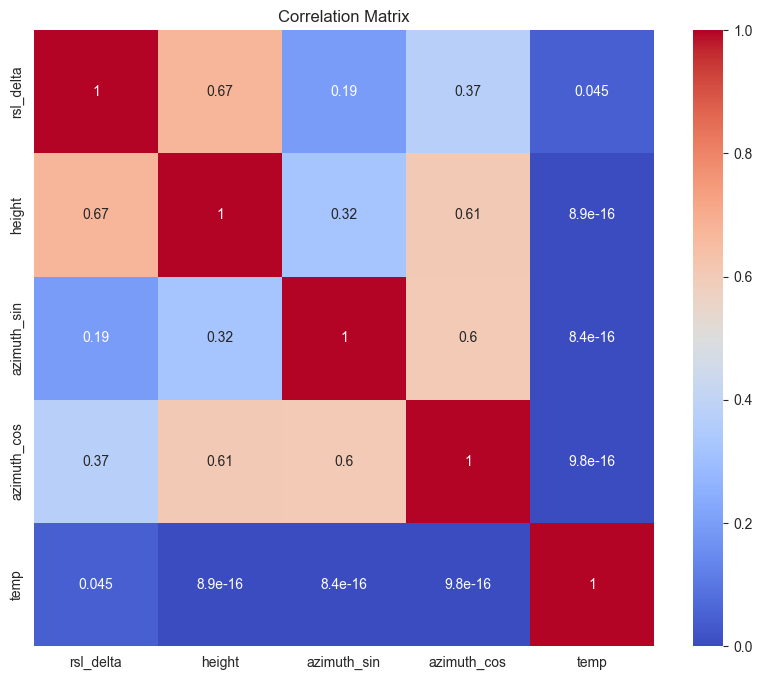

In [349]:
corr_matrix = df[['rsl_delta', 'height', 'azimuth_sin', 'azimuth_cos', 'temp']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Bar graphs visualizing the maximum RSL deviance at various heights and azimuths

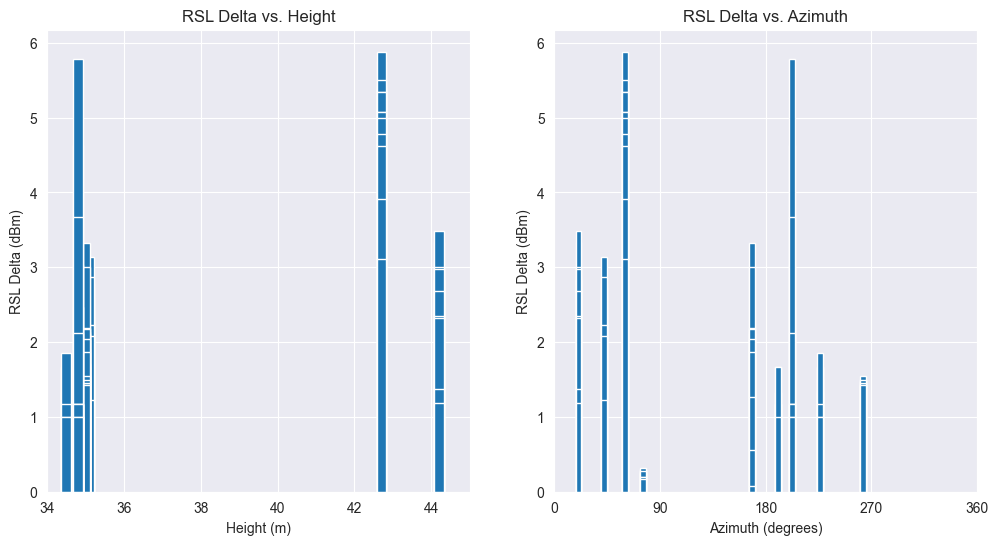

In [350]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)

plt.bar(df['height'], df['rsl_delta'], width=.25)

plt.xlim(34, 45)
plt.xlabel('Height (m)')
plt.ylabel('RSL Delta (dBm)')
plt.title('RSL Delta vs. Height')

plt.subplot(1, 2, 2)

plt.bar(df['azimuth'], df['rsl_delta'], width=5)

plt.xticks([0, 90, 180, 270, 360])
plt.xlabel('Azimuth (degrees)')
plt.ylabel('RSL Delta (dBm)')
plt.title('RSL Delta vs. Azimuth')

plt.show()

Interactive Temperature vs RSL plot

In [351]:
link_names = df['link_name'].unique()

dropdown = Dropdown(
    options=link_names,
    description='Select Link: ',
)

def plot_temp_rsl_change(link_name='noc_bv'):
    
    link_data = df[df['link_name'] == link_name]
    
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    ax1.plot(link_data['time'], link_data['temp'], alpha = 0.5, label='Temperature', color='red')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Temperature C')
    ax1.tick_params(axis='y')
    
    ax2 = ax1.twinx()
    ax2.plot(link_data['time'], link_data['rsl'], alpha=0.5, label='RSL', color='blue')
    ax2.set_ylabel('RSL')
    ax2.tick_params(axis='y')
    
    plt.show()
    
interact(plot_temp_rsl_change, link_name=dropdown)

interactive(children=(Dropdown(description='Select Link: ', options=('noc_bz', 'noc_bv', 'noc_col', 'noc_gwt',…

<function __main__.plot_temp_rsl_change(link_name='noc_bv')>

Interactive predictive plot of potential RSL deviance at specific height and azimuth

In [352]:
def plot_rsl_change(input_height=35, input_azimuth=0):
    temperatures = np.arange(10, 35, 0.1)
    predicted_rsl = []

    for temp in temperatures:
        inputs = pd.DataFrame({
            'temp': [temp], 'height': [input_height],
            'azimuth_sin': [np.sin(np.radians(input_azimuth))],
            'azimuth_cos': [np.cos(np.radians(input_azimuth))]
        })
        predicted_rsl.append(model.predict(inputs)[0])

    smooth_plot = pd.DataFrame({'rsl_change': predicted_rsl})
    smooth_plot['rsl_change_smooth'] = smooth_plot['rsl_change'].rolling(window=50, center=True).mean()
    
    plt.figure(figsize=(10, 6))
    plt.plot(temperatures, predicted_rsl, alpha = 0.5)
    plt.plot(temperatures, smooth_plot['rsl_change_smooth'], linestyle='--')
    
    plt.xlabel('Temperature (°C)')
    plt.ylabel('Potential RSL Change (dBm)')
    plt.yticks(np.arange(0, 20, 0.5))
    plt.ylim(0, 5)
    plt.title(f'RSL Change vs. Temperature (Height: {input_height}m, Azimuth: {input_azimuth}°)')
    plt.grid(True)
    plt.show()


interact(plot_rsl_change,
         input_height=widgets.IntSlider(min=30, max=50, step=1, value=35, description='Height (m)'),
         input_azimuth=widgets.IntSlider(min=0, max=360, step=1, value=180, description='Azimuth (°)')
         )

interactive(children=(IntSlider(value=35, description='Height (m)', max=50, min=30), IntSlider(value=180, desc…

<function __main__.plot_rsl_change(input_height=35, input_azimuth=0)>